# vta MC2: Fourier Transformation


## Voraussetzungen


In [1]:
%pip install numpy matplotlib scipy librosa soundfile


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# FFT
from scipy.fft import fft, ifft, fftshift, ifftshift, fftfreq

# Sunspots handling
from scipy.signal import find_peaks

# Audio handling
from IPython.display import Audio 
import soundfile as sf
import librosa
import librosa.display

# Image handling
import matplotlib.image as mpimg
from scipy.fft import fft2, ifft2

# Plot config
%matplotlib inline
plt.rcParams ['figure.figsize'] = [14, 5]
# %config InlineBackend.figure_format = 'retina'  # for better quality plots

## Aufgabe 1 - Fourier-Approximation

> In dieser Aufgabe implementieren Sie die Berechnung der Fourier-Approximation in `numpy` (kein fft).


### (a) - Fourier-Komponenten
> Implementieren Sie mit numpy eine Methode zur Berechnung der $k$-ten Fourier-Komponente einer Funktion, gegeben durch Arrays $x$ und $y$, mithilfe der Trapezregel (`np.trapz`).


$$
{\displaystyle c_{n}={\frac {1}{P}}\int _{-P/2}^{P/2}s(x)e^{-{\frac {2\pi inx}{P}}}\,dx\qquad {\text{for all integers}}~n}
$$


In [3]:
def fourier_coefficient(x, y, k, P):
    """
    Calculates the k-th Fourier coefficient for the given function values.

    Args:
        x (numpy.array): The x-values of the function.
        y (numpy.array): The y-values of the function.
        k (int): The order of the Fourier coefficient.
        P (float): The period of the function.

    Returns:
        complex: The k-th Fourier coefficient.
    """
    return (1 / P) * np.trapz(y * np.exp(-1j * 2 * np.pi * k * x / P), x)

### (b) - Fourier-Approximation
> Implementieren Sie mit numpy eine Methode zur Berechnung der Fourier-Approximation $f_{app}$ mit einer gegebenen Anzahl ($2m + 1$) von Fourier-Komponenten.

$$
{\displaystyle s(x)=\sum _{n=-\infty }^{\infty }c_{n}\cdot e^{\frac {2\pi inx}{P}}}
$$


In [4]:
def fourier_approximation(f, a, N, m):
    """
    Calculates the Fourier approximation of a given function.

    Args:
        f (function): The function to approximate.
        a (float): The interval length. The function will be approximated over [-a, a].
        N (int): The number of points to use in the approximation.
        m (int): The number of Fourier components to use in the approximation. The total number of components is 2m + 1.

    Returns:
        x (numpy.array): The x-values used in the approximation.
        y (numpy.array): The actual y-values of the function.
        f_approx (numpy.array): The approximated (real) y-values.
        f_coeff (numpy.array): The calculated Fourier coefficients.
    """
    x = np.linspace(-a, a, N)
    y = f(x)

    P = 2 * a
    f_coeff = np.array(
        [
            fourier_coefficient(x, y, k, P)
            for k in range(-m, m + 1)
        ]
    )

    f_approx = np.sum(
        [
            f_coeff[k + m] * np.exp((1j * 2 * np.pi * k * x) / P)
            for k in range(-m, m + 1)
        ], 
        axis=0
    )

    return x, y, f_approx.real, f_coeff

### (c) - Approximation einer Funktion
>Nähern Sie die Funktion $f_1(x) = \frac{1}{{e^x + e^{-x}}}$ auf dem Intervall $[-3, 3]$ (Auflösung: $N = 600$ Schritte) mit verschiedenen Anzahlen von Komponenten $2m + 1$. Plotten Sie den Vergleich zur Originalfunktion $f$.


$$
\mathrm{RE}=\frac{\left\|f(x)-\hat{f}(x)\right\|}{\|f(x)\|}
$$

wobei $f(x)$ die originale und $\hat{f}(x)$ die approximierte Funktion ist.

In [5]:
def rel_error(y, f_app):
    """
    Calculates the relative error between the actual values and the approximated values.

    Args:
        y (numpy.array): The actual y-values.
        f_app (numpy.array): The approximated y-values.
        
    Returns:
        float: The relative error between y and f_app.
    """
    return np.linalg.norm(y - f_app) / np.linalg.norm(y)

Die folgende Funktion vereinfacht die wiederholte Berechnungen und Darstellungen der Approximationen:

In [6]:
def plot_fourier_approx_and_err(f, a, N, m_values, calc_error=False, err_thresh=.001):
    """
    Plots the Fourier approximation of a given function and optionally calculates and plots the relative error.

    Args:
        f (function): The function to approximate.
        a (float): The interval length. The function will be approximated over [-a, a].
        N (int): The number of points to use in the approximation.
        m_values (list of int): List of the number of Fourier components to use in the approximations.
        calc_error (bool, optional): If true, calculate and plot the relative error. Defaults to False.
        err_thresh (float, optional): The error threshold. Used to draw a line on the error plot and print the minimum m. Defaults to .001.

    Returns:
        list of float: The relative errors for each approximation. Only returned if calc_error is True.
    """
    errors = []
    for i, m in enumerate(m_values):
        x, y, f_app, f_coeff = fourier_approximation(f=f, a=a, N=N, m=m)

        label_str = f"m = {m}"
        if calc_error:
            error = rel_error(y, f_app)
            errors.append(error)
            
            label_str += f", err = {error:.3f}"

        if i <= 3 or i == len(m_values) - 1:
            plt.plot(x, f_app, label=label_str)

    # Plot the original function
    plt.plot(x, y, label="Original Function")
    plt.title(f"Fourier Approximation (N={N}, a=[{-a},{a}])")
    plt.legend()
    plt.show()

    if calc_error:
        plt.plot(m_values, errors)
        plt.xlabel("Components (m)")
        plt.ylabel("Relative Error")
        plt.axhline(y=err_thresh, color="r", linestyle="--", label=f"{err_thresh*100}%")
        plt.title(f"Relative Error")
        plt.legend()
        plt.show()

        # Print the lowest number of components needed to be lower equal than the err_thresh
        try:
            indices = np.where(np.array(errors) <= err_thresh)[0]
            min_m_value = m_values[indices.min()]
            print(f"The lowest number of components needed to have an error lower or equal {err_thresh*100}% is: {min_m_value}")
        except ValueError:
            print(f"No components yield an error lower or equal to {err_thresh*100}%.")

    return errors if calc_error else None


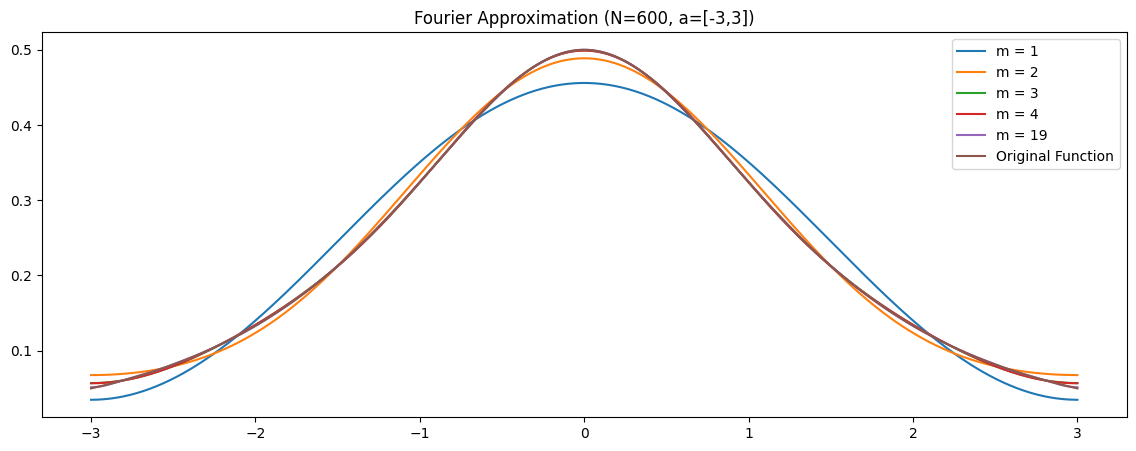

In [7]:
def f1(x):
    """
    Compute the value of f1(x) = 1 / (exp(x) + exp(-x)).

    Args:
        x (float or numpy.array): Input value(s) for the function.

    Returns:
        float or numpy.array: Result of the function evaluation at x.
    """
    return 1 / (np.exp(x) + np.exp(-x))

plot_fourier_approx_and_err(f=f1, a=3, N=600, m_values=list(range(1, 20)))

### (d) - Fehlerberechnung
>Bestimmen Sie die Anzahl der Fourier-Komponenten, die benötigt werden, um eine Approximation mit höchstens $0,1$% relativen Fehler zu erhalten.

> **Note**: Um den relativen Fehler zu berechnen verwenden wir die bereits unter **(c)** notierte $RE$-Metrik.

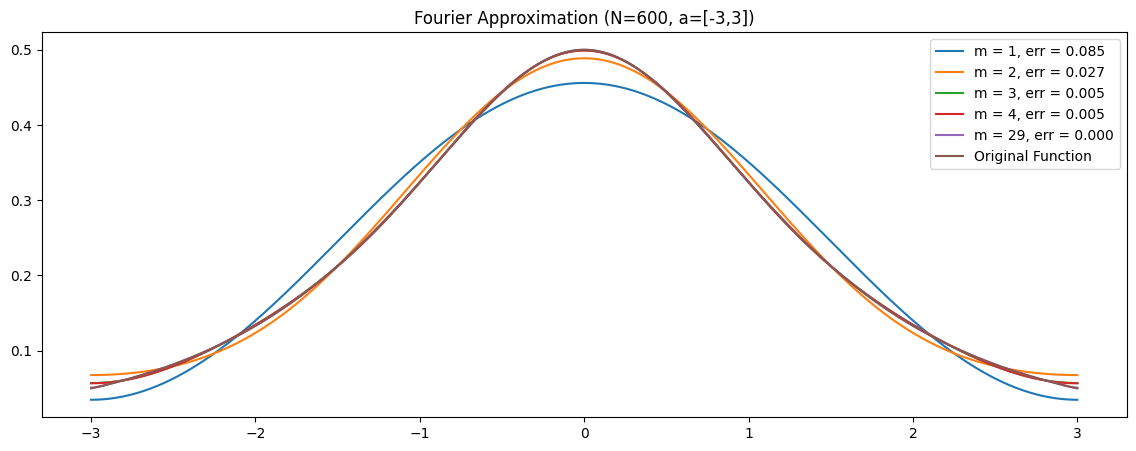

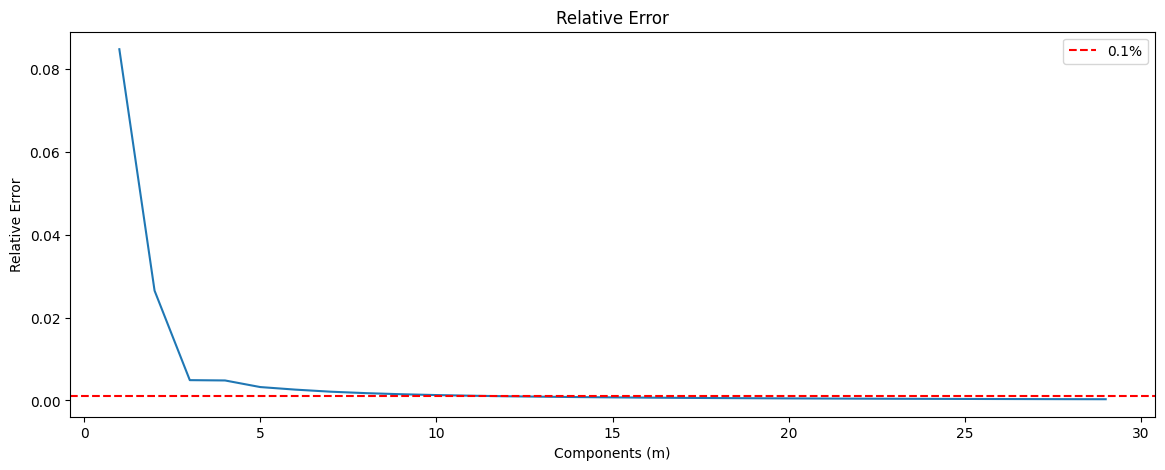

The lowest number of components needed to have an error lower or equal 0.1% is: 13


In [8]:
errors = plot_fourier_approx_and_err(f=f1, a=3, N=600, m_values=list(range(1, 30)), calc_error=True)

### (e) - Approximation weiterer Funktionen
> Versuchen Sie die Funktionen $f_2(x) = e^x$ und $f_3(x) = e^{abs(x)}$ auf dem Intervall ($[-3, 3]$) (Auflösung: ($N = 600$ Schritte) mit einem $0,1$%igen Approximationsfehler anzunähern. Beschreiben und erklären Sie die Unterschiede.


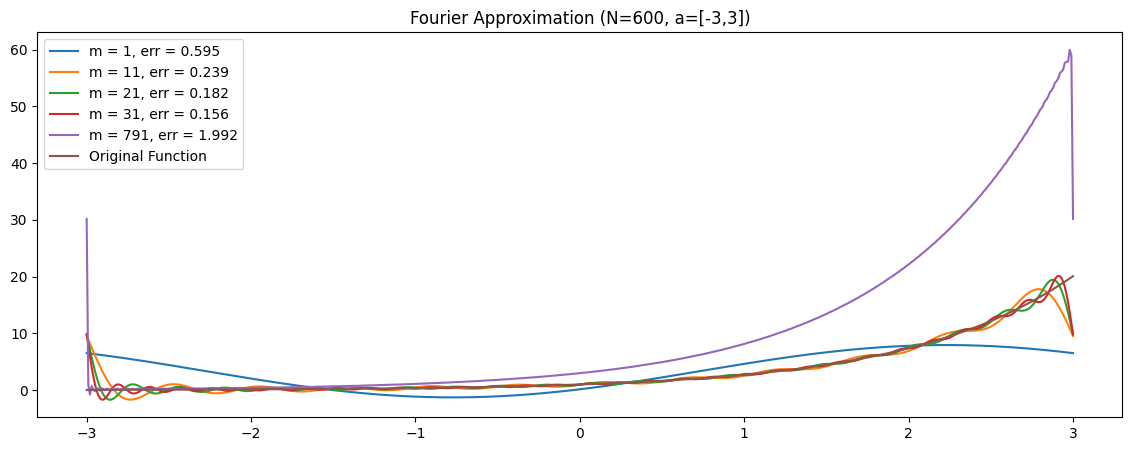

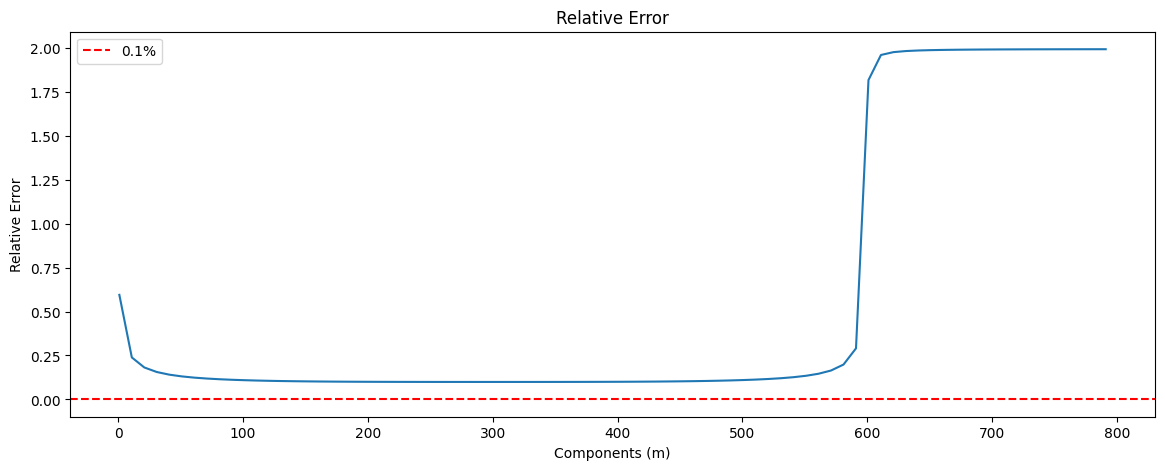

No components yield an error lower or equal to 0.1%.


In [10]:
def f2(x):
    """
    Compute the value of f2(x) = exp(x).

    Args:
        x (float or numpy.array): Input value(s) for the function.

    Returns:
        float or numpy.array: Result of the function evaluation at x.
    """
    return np.exp(x)

errors = plot_fourier_approx_and_err(f=f2, a=3, N=600, m_values=list(range(1, 800, 10)), calc_error=True)

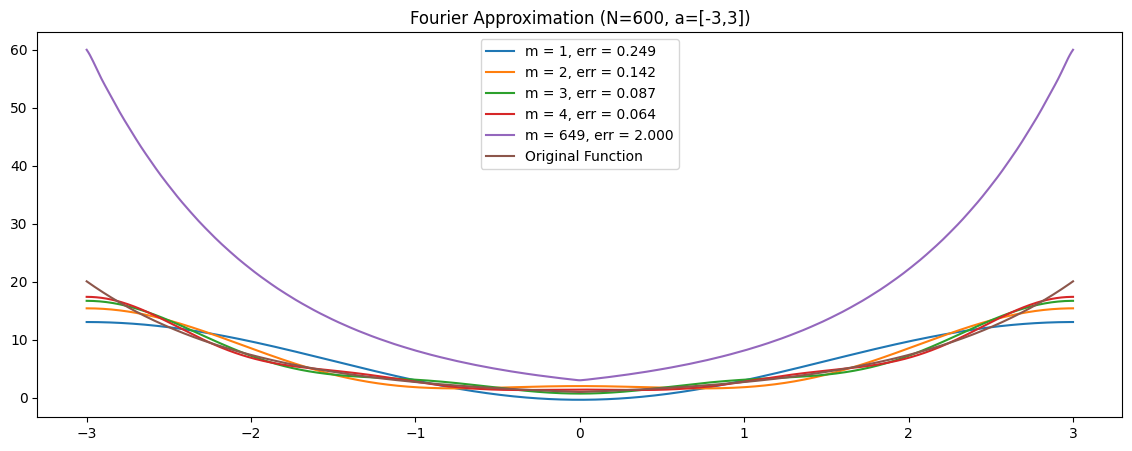

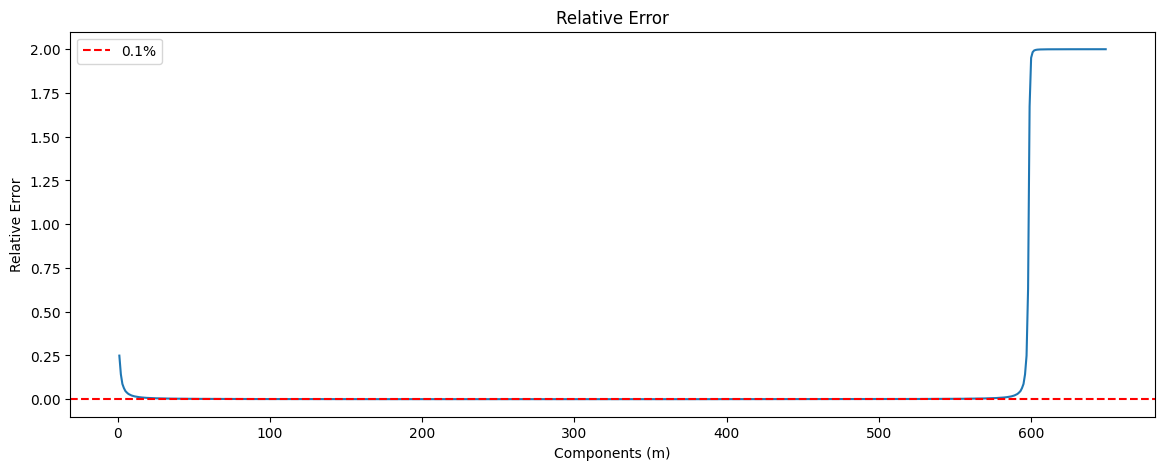

The lowest number of components needed to have an error lower or equal 0.1% is: 93


In [15]:
def f3(x):
    """
    Compute the value of f3(x) = exp(abs(x)).

    Args:
        x (float or numpy.array): Input value(s) for the function.

    Returns:
        float or numpy.array: Result of the function evaluation at x.
    """
    return np.exp(np.abs(x))

errors = plot_fourier_approx_and_err(f=f3, a=3, N=600, m_values=list(range(1, 650)), calc_error=True)

#### Interpretation der Approximation der Funktionen $f_1$, $f_2$ und $f_3$
In diesem Abschnitt werden die einzelnen Approximationen bzw. deren Resultate genau beschrieben.

##### Funktion $f_1$
Für die erste Funktion gilt, dass der relative Fehler bei Komponente $13$ einen Wert unter $0.1\%$ annimmt.

##### Funktion $f_2$
Der Fehler scheint bei $800$ Komponenten **nie** einen Fehler unter $0.1\%$ zu erreichen.

##### Funktion $f_3$
Wir können beobachten, dass der relative Fehler von $1$ bis $800$ Komponenten bei einer Auflösung von $N=600$ den tiefsten Fehler bei $93$ Komponenten annimmt. 

##### Allgemeine Beobachtung
Je näher die Komponentenanzahl an der Auflösung liegt, desto höher ist der relative Fehler; Konvergiert maximal zu $2$ (relativ doppelter Fehler).

## Aufgabe 2 - Sonnenflecken

>In dieser Aufgabe wenden Sie die Fourier-Analyse auf Sonnenfleckendaten an (`sunspots.txt`). Sie dürfen dafür die fft routine von `numpy` oder `scipy` verwenden.

In [16]:
def load_sunspot_data(path="./data/sunspots.txt"):
    """
    Load sunspot data from a file and return the recorded years and sunspot counts.

    Args:
        path (str, optional): The path to the sunspot data file. Defaults to "./data/sunspots.txt".

    Returns:
        recorded_years (numpy.array): An array containing the recorded years.
        sunspot_counts (numpy.array): An array containing the corresponding sunspot counts.
    """
    sunspot_data = np.loadtxt(path)
    sunspot_data = sunspot_data.reshape(63 * 5, 2)
    recorded_years = sunspot_data[:, 0]
    sunspot_counts = sunspot_data[:, 1]
    return recorded_years, sunspot_counts

recorded_years, sunspot_counts = load_sunspot_data()
recorded_years.shape, sunspot_counts.shape

((315,), (315,))

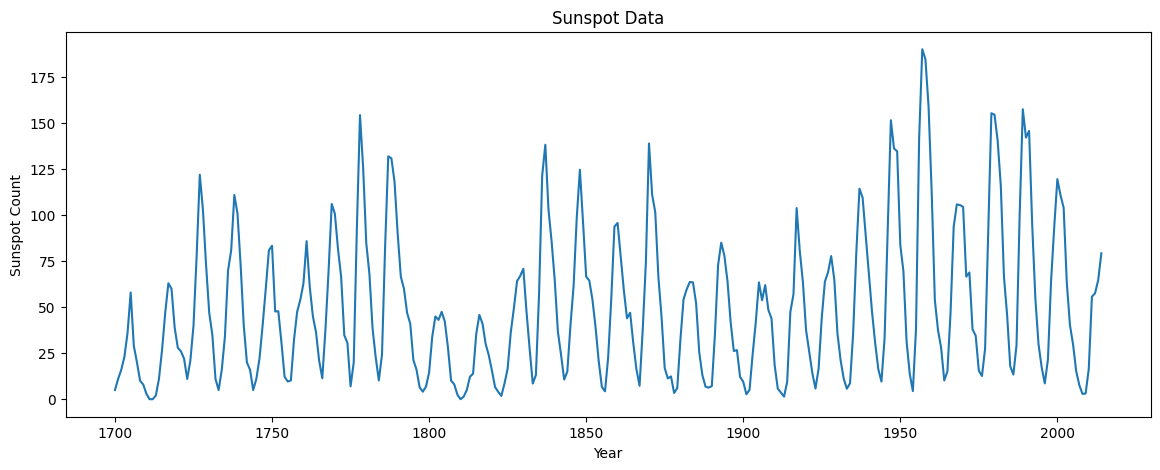

In [17]:
plt.plot(recorded_years, sunspot_counts)
plt.title("Sunspot Data")
plt.xlabel("Year")
plt.ylabel("Sunspot Count")
plt.show()

In [18]:
# Frequency calculation
num_years = len(recorded_years)
sampling_interval = recorded_years[1] - recorded_years[0]  # Sampling Interval
sampling_rate = 1 / sampling_interval  # Sampling Rate

# FFT
fft_values = fft(sunspot_counts)
frequencies = fftfreq(len(sunspot_counts), sampling_rate)

# Create a list of positive frequencies for later usage
positive_frequencies = frequencies[frequencies > 0]
positive_fft_values = fft_values[frequencies > 0]

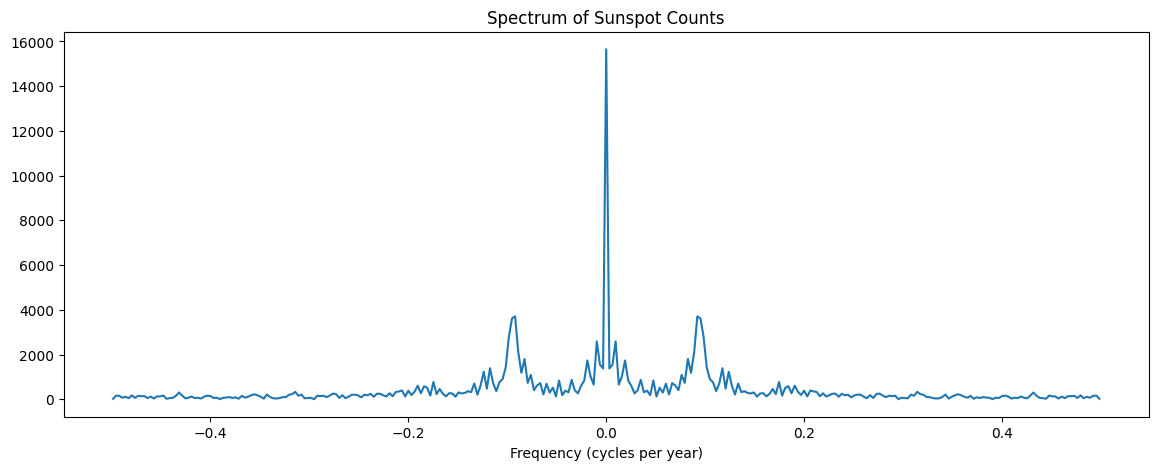

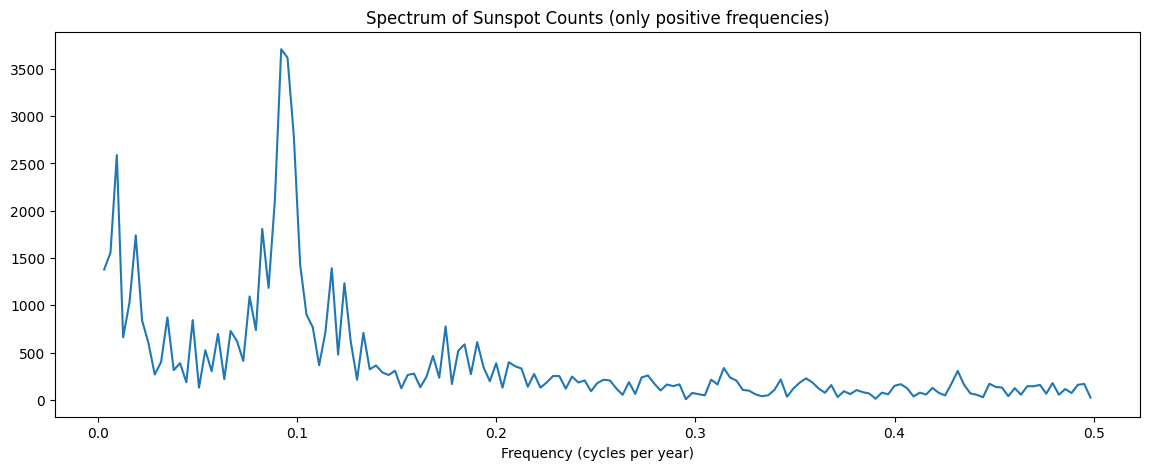

In [19]:
plt.plot(fftshift(frequencies), np.abs(fftshift(fft_values)))
plt.xlabel("Frequency (cycles per year)")
plt.title("Spectrum of Sunspot Counts")
plt.show()

plt.plot(positive_frequencies, np.abs(positive_fft_values))
plt.xlabel("Frequency (cycles per year)")
plt.title("Spectrum of Sunspot Counts (only positive frequencies)")
plt.show()

### (a) - Power Spektrum & dominante Periodizität
>Plotten Sie das Power-Spektrum und finden Sie die dominante Periodizität der Schwingung. Damit erhalten Sie eine Abschätzung auf die Dauer des Sonnenzyklus.

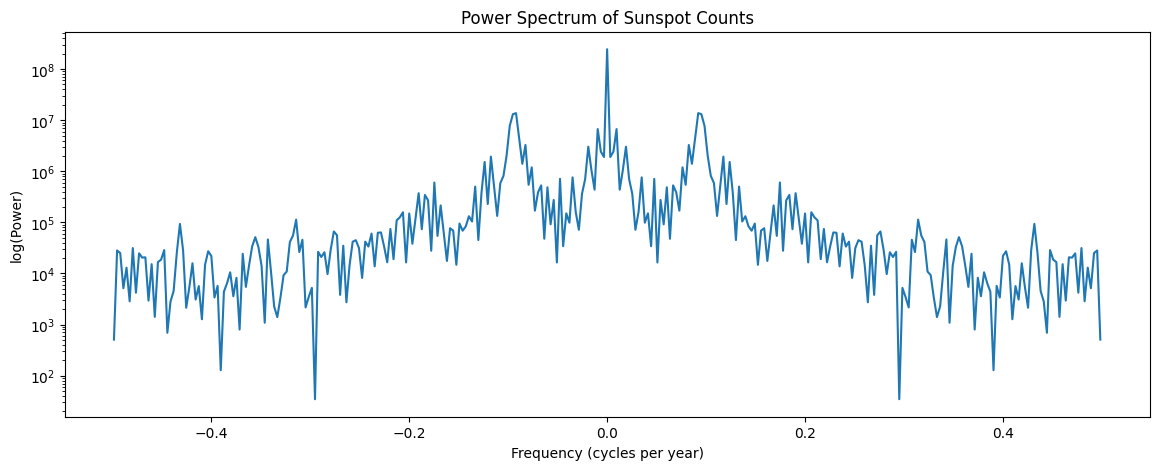

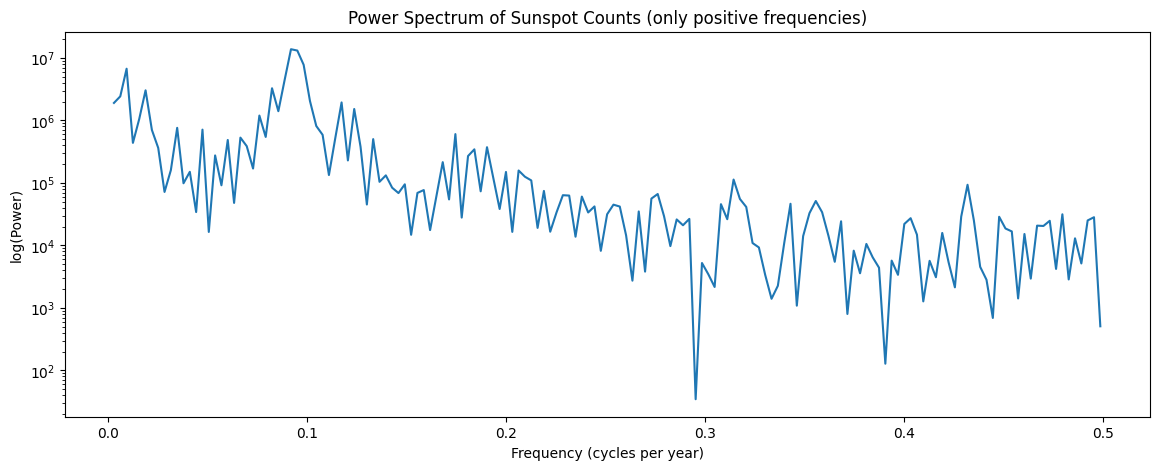

In [20]:
plt.plot(fftshift(frequencies), np.abs(fftshift(fft_values)) ** 2)
plt.xlabel("Frequency (cycles per year)")
plt.ylabel("log(Power)")
plt.title("Power Spectrum of Sunspot Counts")
plt.yscale('log')
plt.show()

plt.plot(positive_frequencies, np.abs(positive_fft_values) ** 2)
plt.xlabel("Frequency (cycles per year)")
plt.ylabel("log(Power)")
plt.title("Power Spectrum of Sunspot Counts (only positive frequencies)")
plt.yscale('log')
plt.show()

In [21]:
peak_frequency = positive_frequencies[np.argmax(np.abs(positive_fft_values))]
print(f"Peak Frequency (Dominant Frequency): {1 / peak_frequency} years")

Peak Frequency (Dominant Frequency): 10.86206896551724 years


### (b) - Weitere Perioden
> Können Sie weitere Perioden in den Sonnenfleck-Daten mithilfe des Fourier-Spektrums finden?

Dominant frequencies in the spectrum (descending):
1. 10.862 years
2. 105.000 years
3. 12.115 years
4. 52.500 years
5. 8.514 years
6. 8.077 years
7. 13.125 years


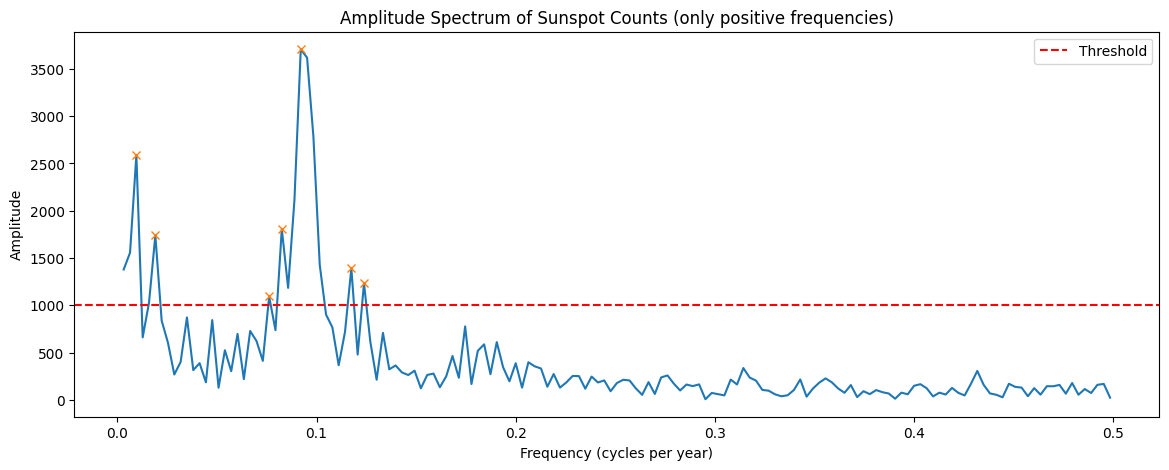

In [22]:
height_threshold = 1e3

# Calculate the absolute values of the FFT results
abs_fft_values = np.abs(positive_fft_values)

# Use scipy's find_peaks function to find the indices of the peaks
peak_indices, _ = find_peaks(abs_fft_values, height=height_threshold)
sorted_peak_indices = peak_indices[np.argsort(abs_fft_values[peak_indices])[::-1]]
sorted_dominant_frequencies = positive_frequencies[sorted_peak_indices]

# Print the frequencies in descending order
print("Dominant frequencies in the spectrum (descending):")
for i, freq in enumerate(sorted_dominant_frequencies, 1):
    print(f"{i}. {1/freq:.3f} years")

plt.figure(figsize=(14, 5))
plt.plot(positive_frequencies, abs_fft_values)
plt.plot(positive_frequencies[peak_indices], abs_fft_values[peak_indices], "x")
plt.axhline(y=height_threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel("Frequency (cycles per year)")
plt.ylabel("Amplitude")
plt.title("Amplitude Spectrum of Sunspot Counts (only positive frequencies)")
plt.legend()
plt.show()

Hier sind einige Quellen, die sich mit der Beobachtung der dominierenden Frequenzen der Sonnenflecken beschäftigen:

1. [The ~11-yr Solar Cycle](https://www.semanticscholar.org/paper/The-~-11-yr-Solar-Cycle-Bacon-Organon/04b1dbf40ac1fccc078b33025c33bc81eea62edd) - Dieser Artikel auf Semantic Scholar untersucht den etwa 11-jährigen Sonnenzyklus und seine Auswirkungen auf das Auftreten von Sonnenflecken.

2. [Power spectrum of the sunspot number fluctuation](https://www.researchgate.net/figure/Power-spectrum-of-the-sunspot-number-fluctuation-The-arrow-indicates-the-peak-at-f-11_fig2_2146547) - In dieser Abbildung auf ResearchGate wird das Leistungsspektrum der Schwankungen der Sonnenfleckenzahl dargestellt. Der Pfeil zeigt auf den Peak bei der Frequenz f = 11, der auf den dominanten 11-jährigen Zyklus hinweist.

3. [Dominant frequencies of sunspots](https://www.worldscientific.com/doi/10.1142/S0218348X08004009) - Dieser Artikel auf World Scientific untersucht die dominierenden Frequenzen der Sonnenfleckenaktivität und beschäftigt sich mit ihrer periodischen Natur.

Die ~11 Jahres Frequenz die wir in den Daten beobachten könnenten, scheint also auch schon in anderer Literatur entdeckt worden zu sein.

### (c) - Filtern von Komponenten

>Entfernen Sie einige Komponenten im Fourier-Spektrum und führen dann eine Rücktransformation durch:
>- grössten Komponenten entfernen ($k > 20$)
>- kleinsten Komponenten entfernen ($k < 5$)
>Beschreiben und erklären Sie die Ergebnisse.

In [23]:
filter_below_5 = (np.abs(frequencies) > 1 / 5) | (frequencies == 0) # 5 years k < 5
filter_above_20 = np.abs(frequencies) < 1 / 20 # 20 years k > 20

fft_values_below_5 = fft_values * filter_below_5
fft_values_above_20 = fft_values * filter_above_20

Die Null-Frequenzkomponente einer Fourier-Transformation repräsentiert den Durchschnitt oder die Gleichstromkomponente (DC-Component) des Signals. Mit anderen Worten, es ist der konstante Versatz des Signals von Null.

Für einige Analysen ist die Null-Frequenzkomponente möglicherweise nicht sehr interessant, insbesondere wenn man sich auf die periodischen oder oszillatorischen Aspekte der Daten konzentriert. Für andere Analysen kann sie jedoch entscheidend sein. Wenn man beispielsweise ein Signal mit einem von Null verschiedenen Mittelwert untersucht, repräsentiert die Null-Frequenzkomponente diesen Mittelwert. Wenn man sie entfernt, würde man das Signal effektiv mitteln, was die Interpretation der Ergebnisse beeinflussen könnte.

Wenn also wie in diesem Fall das Signal eine signifikante Gleichstromkomponente hat (Mittelwert signifikant von Null verschieden), zeigt sich dies als Spitze bei der Nullfrequenz. Wenn diese herausgefiltert wird, würde die Charakteristik der Daten ignoriert werden. Die mathematische Intuition hinter dem Nicht-Filtern der Nullfrequenz besteht also darin, den Mittelwert des Signals beizubehalten.

Um diesem Problem vorzubeugen, hätte man die Daten vor der Transformation auch so normalisieren können, dass der Durchschnitt der y-Werte bei null liegt.

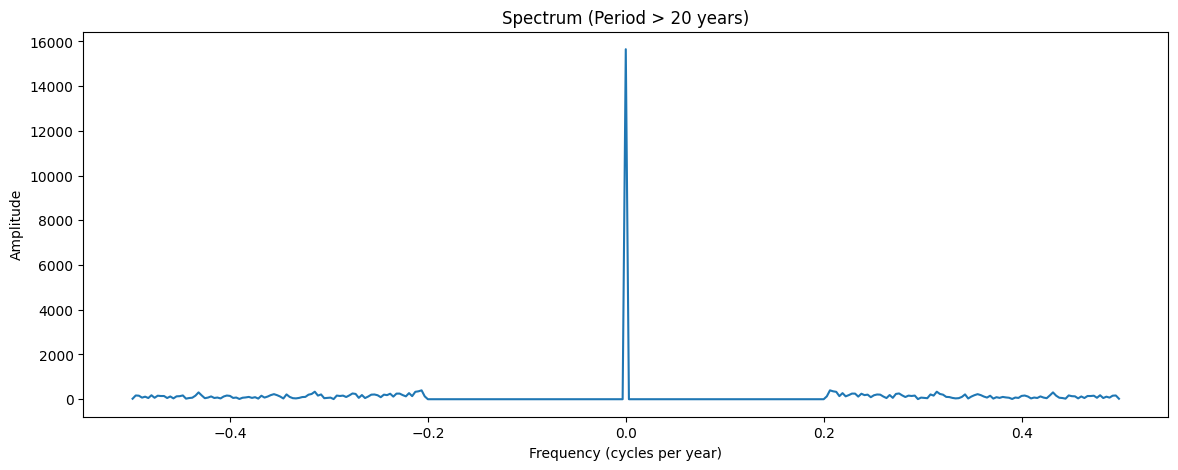

In [24]:
plt.plot(fftshift(frequencies), np.abs(fftshift(fft_values_below_5)))
plt.xlabel("Frequency (cycles per year)")
plt.ylabel("Amplitude")
plt.title("Spectrum (Period > 20 years)")
plt.show()

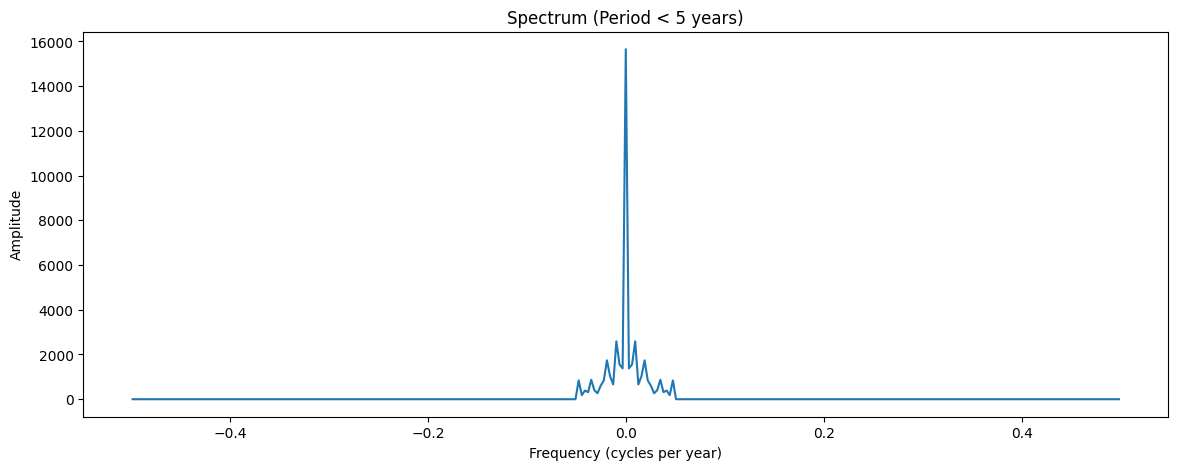

In [25]:
plt.plot(fftshift(frequencies), np.abs(fftshift(fft_values_above_20)))
plt.xlabel("Frequency (cycles per year)")
plt.ylabel("Amplitude")
plt.title("Spectrum (Period < 5 years)")
plt.show()

In [26]:
# Back to time domain
filtered_sunspots_above_5 = ifft(fft_values_below_5).real
filtered_sunspots_below_20 = ifft(fft_values_above_20).real

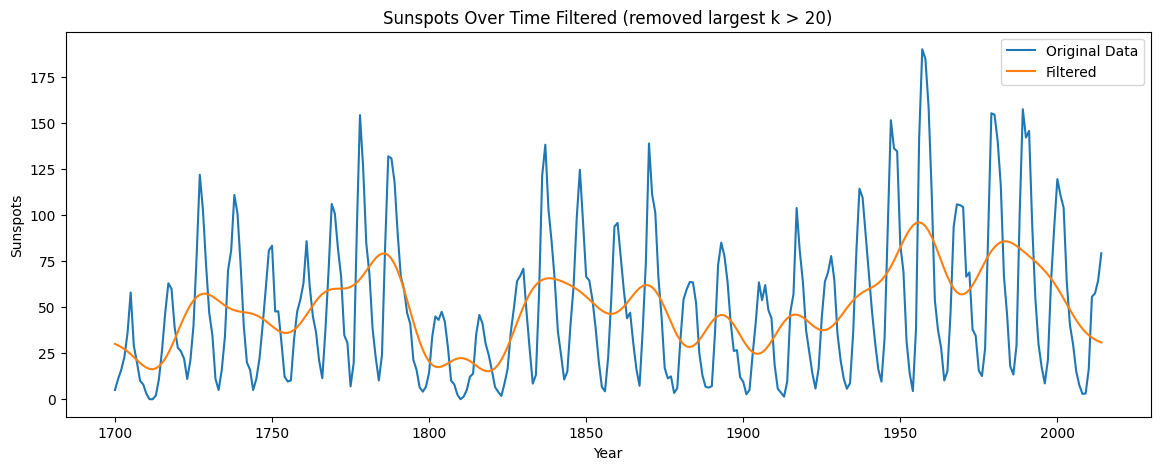

In [27]:
plt.plot(recorded_years, sunspot_counts, label="Original Data")
plt.plot(
    recorded_years,
    filtered_sunspots_below_20,
    label="Filtered",
)
plt.xlabel("Year")
plt.ylabel("Sunspots")
plt.title("Sunspots Over Time Filtered (removed largest k > 20)")
plt.legend()
plt.show()

Wenn die grössten Komponenten ($k > 20$) enfernt werden, werden die schnellen Schwankungen oder "Rauschen" aus den Daten entfernt. Dies führt zu einer Glättung der Daten, da nur die grundlegenden Trends übrig bleiben. Das kann beispielsweise in Anwendungen nützlich sein, in denen Sie an langfristigen Trends interessiert sind und kurzfristige Schwankungen als Störungen betrachten.

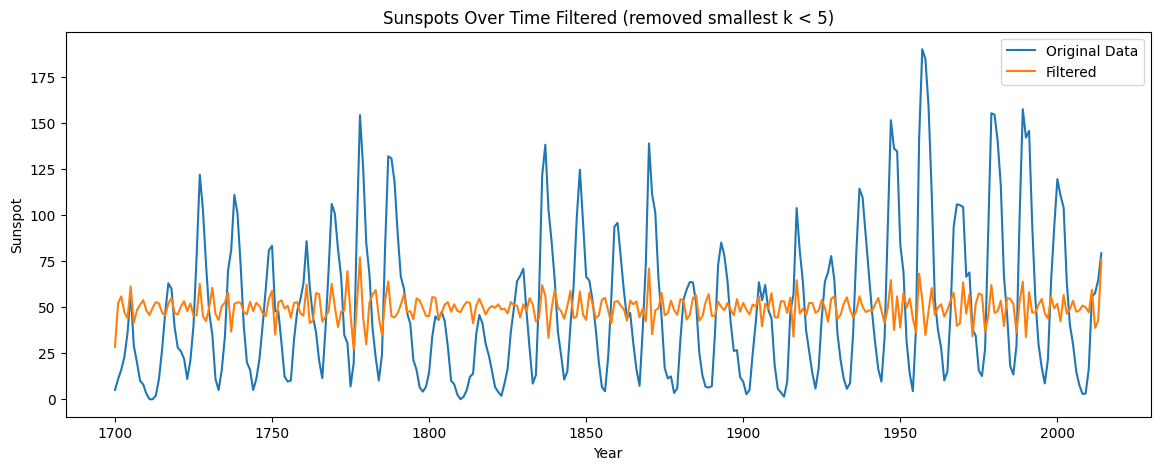

In [28]:
plt.plot(recorded_years, sunspot_counts, label="Original Data")
plt.plot(
    recorded_years, filtered_sunspots_above_5, label="Filtered"
)
plt.xlabel("Year")
plt.ylabel("Sunspot")
plt.title("Sunspots Over Time Filtered (removed smallest k < 5)")
plt.legend()
plt.show()

Wenn die kleinsten Komponenten ($k < 5$) enfernt werden, werden die grundlegenden Trends enfernt und die schnellen Schwankungen behalten. Das Ergebnis sieht sehr rauschhaft aus, da die langsam variierenden Komponenten, die den grundsätzlichen Charakter der Daten ausmachen, fehlen.

### (d) - Unterschiede zu den Fourier-Koeffizienten in Aufgabe 1

> Vergleichen Sie die Ergebnisse mit denen aus Aufgabe 1. Beschreiben und erklären Sie Unterschiede in den Fourier-Koeffizienten.

Wir vergleichen dabei die Koeffizienten der Sonnenflecken Daten zu denen der drei Funktionen aus `Aufgabe 1`. Als Erinnerung:
- $f_1(x) = \frac{1}{{e^x + e^{-x}}}$
- $f_2(x) = e^x$
- $f_3(x) = e^{abs(x)}$

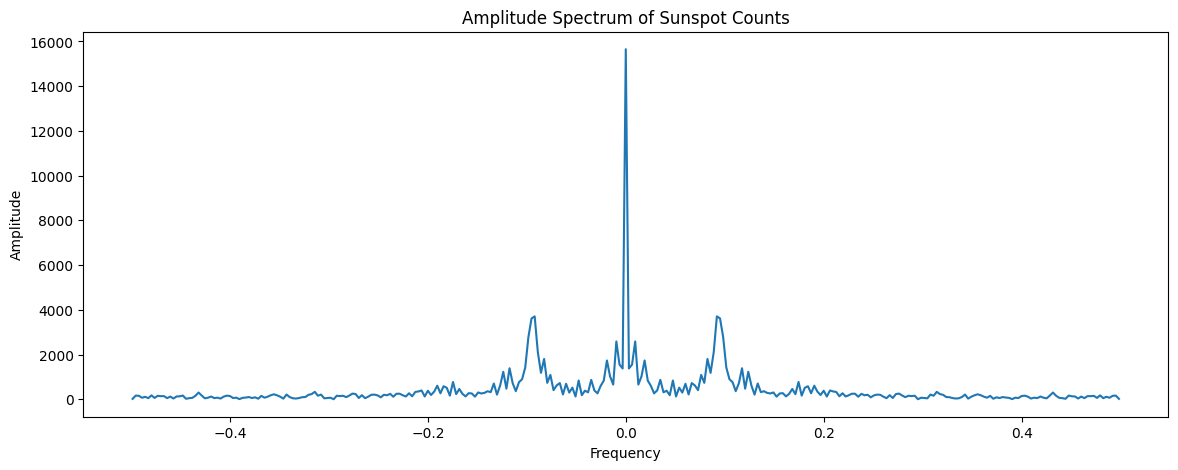

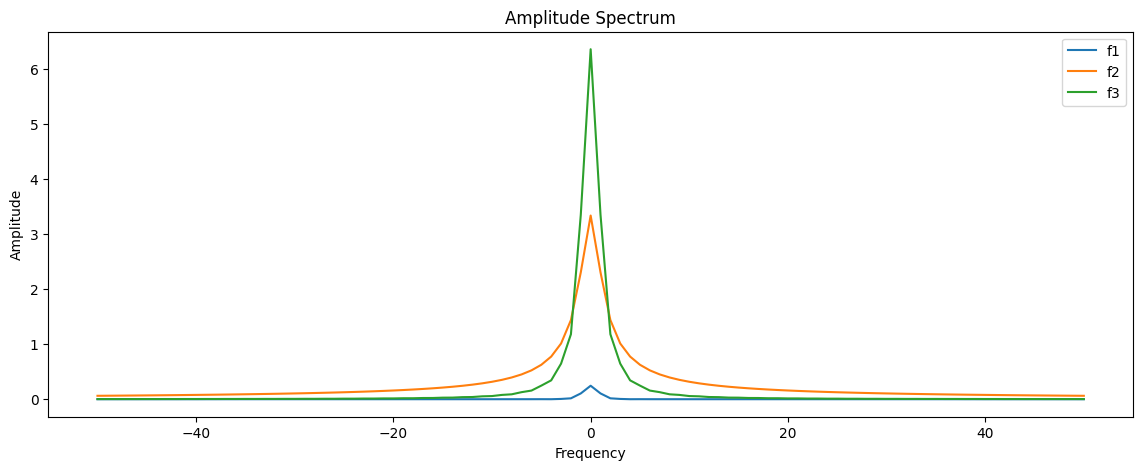

In [29]:
# Plotting sunspot fourier coefficients
plt.plot(fftshift(frequencies), np.abs(fftshift(fft_values)))
plt.title("Amplitude Spectrum of Sunspot Counts")
plt.ylabel("Amplitude")
plt.xlabel("Frequency")
plt.show()

functions_task1 = [f1, f2, f3]
for i, f in enumerate(functions_task1):
    _, _, _, f_coeff = fourier_approximation(f=f, a=3, N=600, m=50)
    plt.title("Amplitude Spectrum")
    plt.xlabel("Frequency")
    plt.ylabel("Amplitude")
    plt.plot(np.arange(-50, 51), np.abs(f_coeff), label=f"f{i+1}")

plt.legend()
plt.show()

Es ist wichtig zu beachten, dass der Vergleich der Fourier-Koeffizienten von zwei unterschiedlichen Funktionen oder Datensätzen (in diesem Fall Sonnenfleckendaten und den Funktionen aus `Aufgabe 1`) nicht unbedingt sinnvolle Einblicke liefert, da die Koeffizienten spezifisch für die jeweilige Funktion oder die Daten sind. Sie repräsentieren die Stärke der verschiedenen periodischen Komponenten in den Daten oder der Funktion.

Dennoch können wir einige allgemeine Überlegungen anstellen:
- Die Fourier-Koeffizienten der Sonnenfleckendaten werden zeigen mehrere dominante Frequenzen, die unter andrem den bekannten Sonnenzyklen entsprechen. Diese erscheinen als Spitzen im Frequenzspektrum (oder als hohe Werte in den Koeffizienten).

- Für die Funktionen aus `Aufgabe 1` gibt die Fourier-Reihe (abhängig von der Periode der Funktion, die approximiert wird) typischerweise eine abnehmende Amplitude der Koeffizienten mit zunehmender Frequenz, da höhere Frequenzen immer weniger zur Gesamtform der Funktion beitragen.

- In Bezug auf die Werte der Koeffizienten selbst: Da die Sonnenfleckendaten und die Funktionen aus `Aufgabe 1` auf einer unterschiedlicher Skala / Einheit sind, sind die absoluten Werte der Koeffizienten sehr unterschiedlich.

## Aufgabe 3 - Musikbearbeitung
>In dieser Aufgabe analysieren und bearbeiten Sie ein Musikstück (`music.wav`). Sie dürfen dafür zB die fft routine von `numpy` oder `scipy` sowie das `librosa` und `soundfile` paket verwenden.

In [30]:
data, sr = librosa.load("./data/music.wav")
Audio(data, rate=sr)

### (a) - Wellenform des Klangs 
> Plotten Sie die Wellenform des Klangs (waveplot) - einmal vollständig und einmal für einen kleinen Zeitberech, sodass die Wellenform deutlich wird - sowie das Amplitudenspektrum. Wieso ist das Amplitudenspektrum symmetrisch bezüglich des Vorzeichens?

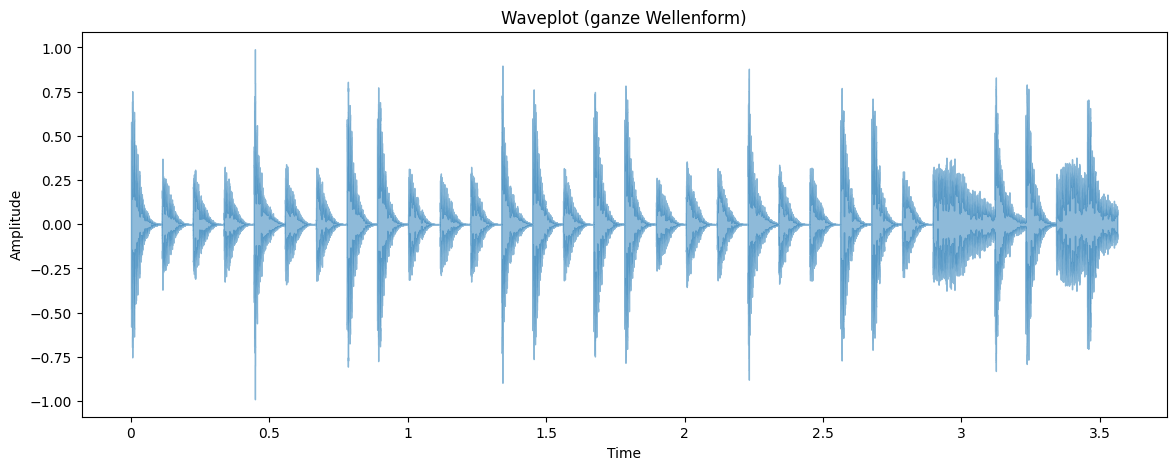

In [31]:
librosa.display.waveshow(data, sr=sr, alpha=.5)
plt.title("Waveplot (ganze Wellenform)")
plt.ylabel("Amplitude")
plt.show()

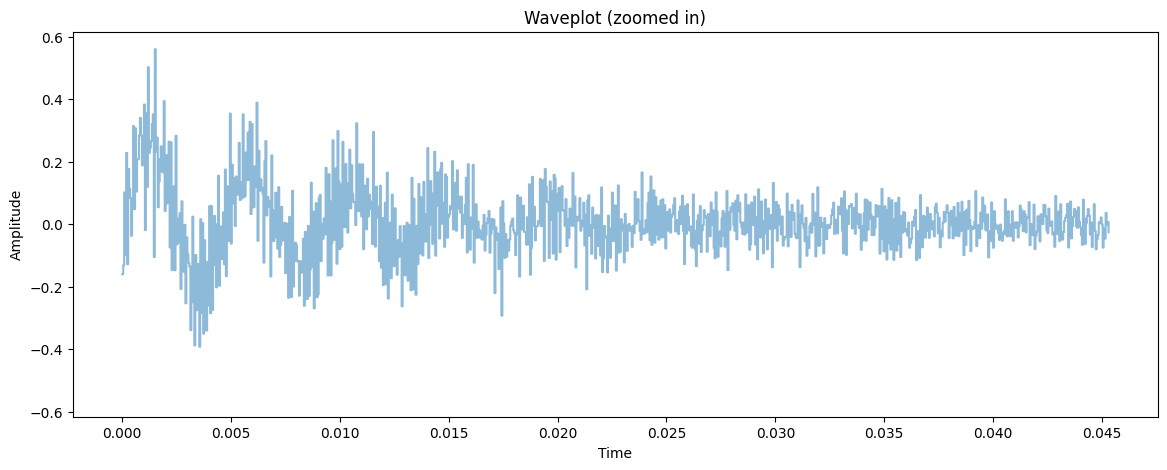

In [32]:
librosa.display.waveshow(data[10000:11000], sr=sr, alpha=.5)
plt.title("Waveplot (zoomed in)")
plt.ylabel("Amplitude")
plt.show()

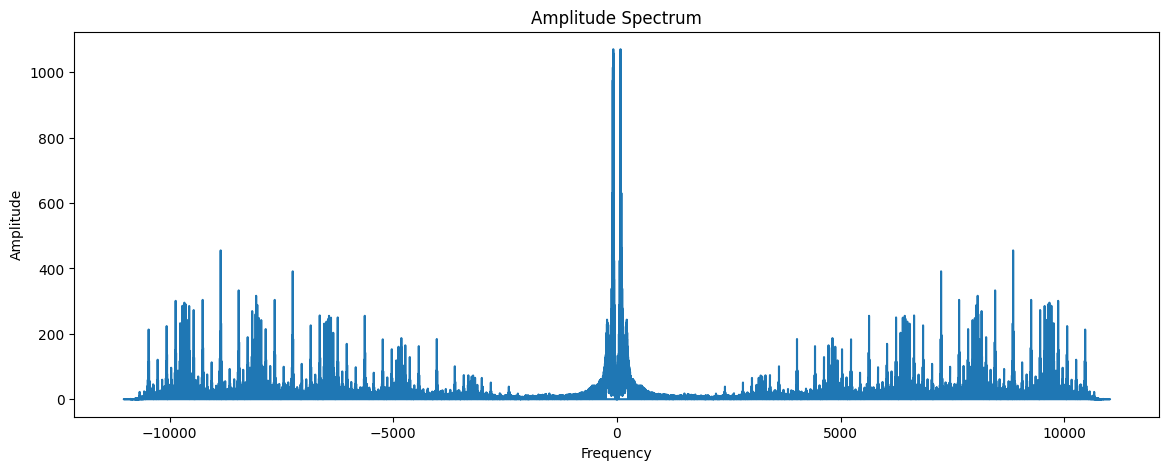

In [33]:
fft_result = fft(data)
frequencies = fftfreq(len(data), 1 / sr)

plt.plot(frequencies, np.abs(fft_result))
plt.title("Amplitude Spectrum")
plt.ylabel("Amplitude")
plt.xlabel("Frequency")
plt.show()

#### Warum ist das Amplitudenspektrum symmetrisch bezüglich des Vorzeichens?

Das Amplitudenspektrum ist symmetrisch bezüglich des Vorzeichens, weil die Fouriertransformation, die zur Berechnung des Amplitudenspektrums verwendet wird, reellwertige Funktionen in komplexe Funktionen umwandelt. Bei reellwertigen Funktionen ist der Realteil des Amplitudenspektrums gerade und der Imaginärteil ungerade. Das bedeutet, dass die Amplituden der positiven und negativen Frequenzkomponenten gleich sind, während die Phasen der negativen Frequenzkomponenten das negative Vorzeichen der Phasen der positiven Frequenzkomponenten haben.

Die Symmetrie des Amplitudenspektrums ist eine direkte Folge der Symmetrie der Fouriertransformation. Die Fouriertransformation einer reellwertigen Funktion $f(t)$ ist gegeben durch:

$$
F(\omega)=\int_{-\infty}^{\infty} f(t) e^{-i \omega t} d t
$$

Da $f(t)$ reellwertig ist, gilt:

$$
F(-\omega)=\int_{-\infty}^{\infty} f(t) e^{i \omega t} d t=F^*(\omega)
$$

Das bedeutet, dass das Amplitudenspektrum, das den Betrag der Fouriertransformierten darstellt, symmetrisch bezüglich des Vorzeichens ist:

$$
|F(-\omega)|=|F(\omega)|
$$

Source:

- [tuwien](https://ti.tuwien.ac.at/cps/teaching/courses/dspv/files/DFT-FFT.pdf)


### (b) - High- und Low-Pass Filter
>Trennen Sie den Sound-Signal in einen Teil oberhalb und unterhalb von $2$kHz in Frequenzen. Identifizieren Sie jeweils die Top 5 Frequenzen in diesen Frequenzbereichen.


In [34]:
mask_below_2kHz = np.abs(frequencies) < 2000
mask_above_2kHz = np.abs(frequencies) > 2000

# Filtern der Frequenzbereiche unter und über 2kHz
fft_below_2kHz = fft_result * mask_below_2kHz
fft_above_2kHz = fft_result * mask_above_2kHz

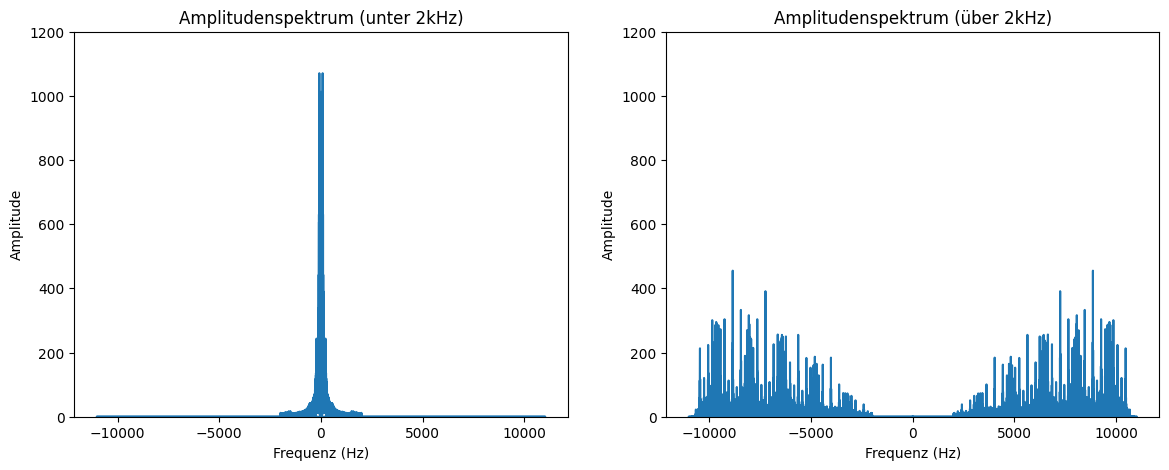

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(frequencies, np.abs(fft_below_2kHz))
ax1.set_title("Amplitudenspektrum (unter 2kHz)")
ax1.set_xlabel("Frequenz (Hz)")
ax1.set_ylabel("Amplitude")

ax2.plot(frequencies, np.abs(fft_above_2kHz))
ax2.set_title("Amplitudenspektrum (über 2kHz)")
ax2.set_xlabel("Frequenz (Hz)")
ax2.set_ylabel("Amplitude")

ax1.set_ylim([0, 1200])
ax2.set_ylim([0, 1200])

plt.show()

In [36]:
positive_frequencies_mask = frequencies >= 0

# Filter out negative frequencies
fft_below_2kHz_positive = fft_below_2kHz[positive_frequencies_mask]
fft_above_2kHz_positive = fft_above_2kHz[positive_frequencies_mask]

frequencies_positive = frequencies[positive_frequencies_mask]

# Identify the top 5 frequencies in these frequency ranges
top_5_freqs_below_2kHz_positive = np.argsort(np.abs(fft_below_2kHz_positive))[-5:]
top_5_freqs_above_2kHz_positive = np.argsort(np.abs(fft_above_2kHz_positive))[-5:]

In [37]:
def print_top_freqs(freqs):
    """
    Print the top frequencies in a given list.

    Args:
        freqs (list or numpy.array): List of frequencies in Hz.

    Returns:
        None
    """
    for freq in sorted(freqs):
        print(f"- {freq:.3f} Hz")

print("Top 5 Frequenzen unter 2kHz: ")
print_top_freqs(frequencies_positive[top_5_freqs_below_2kHz_positive])

print()
print("Top 5 Frequenzen über 2kHz: ")
print_top_freqs(frequencies_positive[top_5_freqs_above_2kHz_positive])

Top 5 Frequenzen unter 2kHz: 
- 71.829 Hz
- 80.807 Hz
- 81.930 Hz
- 89.786 Hz
- 90.908 Hz

Top 5 Frequenzen über 2kHz: 
- 7246.840 Hz
- 8064.733 Hz
- 8454.740 Hz
- 8857.373 Hz
- 9260.007 Hz


### (c) - Fehlerberechnung der Rekonstruktion
> Berechnen Sie aus diesen beiden Teilen jeweils eine Rekonstruktion. Berechnen Sie den Fehler der Rekonstruktion wie in `Aufgabe 1` für die gefilterten Signale und schreiben Sie die gefilterten rekonstruierten Daten in eine `wav`-Datei. Beschreiben und erklären Sie das Ergebnis.

In [38]:
def plot_reconstruction(original, reconstructed, title):
    """
    Plot the original and reconstructed signals.

    Args:
        original (numpy.array): The original signal.
        reconstructed (numpy.array): The reconstructed signal.
        title (str): The title of the plot.

    Returns:
        None
    """
    plt.plot(original, label="Original Signal")
    plt.plot(reconstructed, label="Reconstructed Signal")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

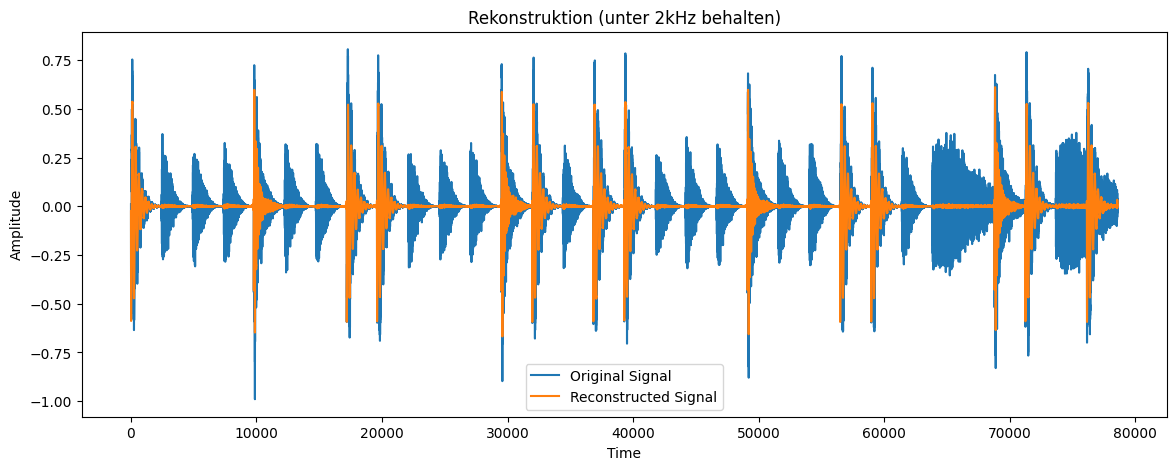

In [39]:
reconstructed_below_2kHz = ifft(fft_below_2kHz).real

plot_reconstruction(data, reconstructed_below_2kHz, "Rekonstruktion (unter 2kHz behalten)")
Audio(data=reconstructed_below_2kHz, rate=sr)

Das Audio, bei welchem die Frequenzen unter $2$kHz behalten wurden, ist beim anhören eher tief. Das ergibt auch Sinn, da hohe Frequenzen aus dem Signal entfernt wurden. Dies ist auch deutlich im Plot zu erkennen.

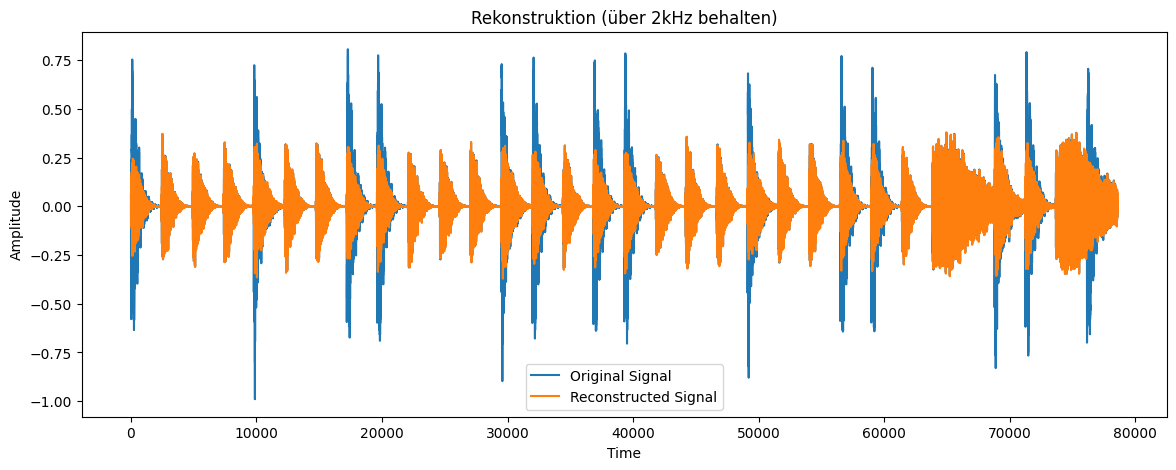

In [40]:
reconstructed_above_2kHz = ifft(fft_above_2kHz).real

plot_reconstruction(original=data, reconstructed=reconstructed_above_2kHz, title="Rekonstruktion (über 2kHz behalten)")
Audio(data=reconstructed_above_2kHz, rate=sr)

Gleich ist es beim Filtern der tiefen Frequenzen: Das Audio ist beim anhöhren eher hoch und man merkt, dass die niedrigeren Frequenzen fehlen. 

In [41]:
print(f"Fehler der Rekonstruktion (unter 2kHz behalten): {rel_error(data, reconstructed_below_2kHz) * 100:.3f} %")
print(f"Fehler der Rekonstruktion (über 2kHz behalten): {rel_error(data, reconstructed_above_2kHz) * 100:.3f} %")

Fehler der Rekonstruktion (unter 2kHz behalten): 57.832 %
Fehler der Rekonstruktion (über 2kHz behalten): 81.581 %


In [42]:
sf.write("reconstructed_below_2kHz.wav", reconstructed_below_2kHz, sr)
sf.write("reconstructed_above_2kHz.wav", reconstructed_above_2kHz, sr)

## Aufgabe 4 - Bildbearbeitung
>In dieser Aufgabe analysieren und bearbeiten Sie eine Bilddatei (`img.jpg`). Sie dürfen dafür die fft routine von `numpy` oder `scipy` verwenden.

In [60]:
def plot_image(img, title, cmap="viridis"):
    """
    Plots an image.

    Args:
        img (numpy.array): The image to plot.
        title (str): The title for the plot.
        cmap (str, optional): The colormap to use. Defaults to "viridis".
    """
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.show()


def plot_spectrum(spectrum, title):
    """
    Plots the Fourier spectrum of an image.

    Args:
        spectrum (numpy.array): The Fourier spectrum to plot.
        title (str): The title for the plot.
    """
    # Take log of spectrum for better visual representation
    # https://www.perplexity.ai/search/7bae3a4c-96d4-4061-9833-289be445fd02?s=c
    plt.imshow(np.log1p(np.abs(spectrum)), cmap='viridis', extent=(-img.shape[1] // 2, img.shape[1] // 2, -img.shape[0] // 2, img.shape[0] // 2))
    plt.title(title)
    plt.colorbar()
    plt.show()


def plot_image_and_spectrum(img, spectrum, title):
    """
    Plots an image and its Fourier spectrum side by side.

    Args:
        img (numpy.array): The image to plot.
        spectrum (numpy.array): The Fourier spectrum to plot.
        title (str): The title for the plot.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2)

    ax1.imshow(img, cmap="gray")
    ax1.set_title("Reconstructed Image")

    # Take logarithm like above or change coloring range to make differences stand out
    #ax2.imshow(np.abs(spectrum), cmap='viridis', extent=(-img.shape[1] // 2, img.shape[1] // 2, -img.shape[0] // 2, img.shape[0] // 2), vmin=0, vmax=6)
    ax2.imshow(np.log1p(np.abs(spectrum)), cmap='viridis', extent=(-img.shape[1] // 2, img.shape[1] // 2, -img.shape[0] // 2, img.shape[0] // 2))

    ax2.set_title("Spectrum")

    plt.suptitle(title)
    plt.show()


def filter_spectrum(spectrum, threshold):
    """
    Filters a Fourier spectrum by a threshold.

    Args:
        spectrum (numpy.array): The Fourier spectrum to filter.
        threshold (float): The threshold value.

    Returns:
        numpy.array: The filtered Fourier spectrum.
    """
    return spectrum * (np.abs(spectrum) > threshold)


def compress_and_reconstruct(img, threshold_percent):
    """
    Compresses an image by filtering its Fourier spectrum and then reconstructs the image.

    Args:
        img (numpy.array): The image to compress and reconstruct.
        threshold_percent (float): The threshold as a percentage of the maximum value in the Fourier spectrum.

    Returns:
        tuple: A tuple containing:
            - img_reconstructed (numpy.array): The reconstructed image.
            - filtered_spectrum (numpy.array): The filtered Fourier spectrum.
            - error (float): The relative error between the original and reconstructed image.
            - data_kept_percentage (float): The percentage of data kept after filtering.
    """
    spectrum = fft2(img)
    spectrum_shifted = fftshift(spectrum)

    # Filtering
    threshold = threshold_percent * np.max(np.abs(spectrum_shifted))
    filtered_spectrum = filter_spectrum(spectrum_shifted, threshold)

    # Compression rate
    data_kept_percentage = np.sum(np.abs(filtered_spectrum)) / np.sum(np.abs(spectrum_shifted))

    # Inverse
    filtered_spectrum_unshifted = ifftshift(filtered_spectrum)
    img_reconstructed = ifft2(filtered_spectrum_unshifted).real

    return img_reconstructed, filtered_spectrum, rel_error(img, img_reconstructed), data_kept_percentage

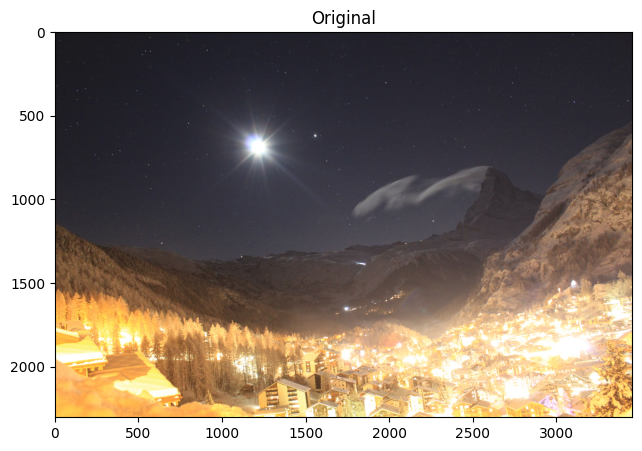

In [61]:
img_original = plt.imread("data/img.jpg")
plot_image(img_original, "Original")

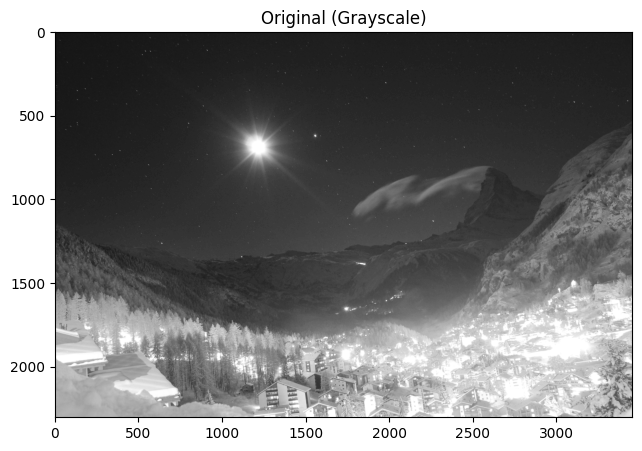

In [62]:
# Making the image greyscale.
# https://stackoverflow.com/a/9827229
img = np.mean(img_original, axis=2)
plot_image(img, "Original (Grayscale)", cmap="gray")

### (a) - Bildspektrum
>Plotten Sie die 2D-Verteilung der absoluten Werte der Fourier-Komponenten, sodass die kleinsten $k$-Werte in der Mitte liegen. Erklären Sie die Natur der Verteilung.

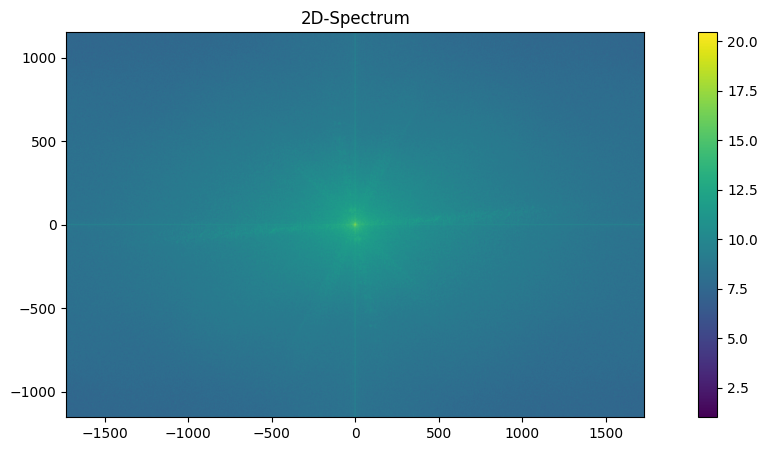

In [63]:
plot_spectrum(fftshift(fft2(img)), "2D-Spectrum")

Die 2D-Verteilung der Fourier-Komponenten zeigt die verschiedenen Frequenzen, die im Bild vorhanden sind. In der Mitte des Plots befinden sich die niedrigen Frequenzen, die für glatte Übergänge und grosse, zusammenhängende Bereiche im Bild verantwortlich sind. Die hohen Frequenzen, die feine Details und Kanten repräsentieren, liegen an den Rändern des Plots. 

Die Farben im Plot zeigen die Amplitude oder Stärke jeder Frequenz an. Helle Farben deuten auf hohe Magnituden hin, was bedeutet, dass diese Frequenzen einen grossen Beitrag zur Bildinformation leisten. Dunkle Farben weisen auf niedrige Magnituden hin, was darauf hindeutet, dass diese Frequenzen einen geringeren Beitrag zur Bildinformation leisten. 

Insgesamt zeigt der Plot, dass die meisten Informationen in natürlichen Bildern in den niedrigen Frequenzen konzentriert sind, während die hohen Frequenzen weniger Energie enthalten.

**Anmerkung**: Für diese Darstellung die absoluten Fourier Komponenten logarithmiert wurden, um den kontrast der Darstellung zu verbessern. Dabei wurde $ln(1 + abs(val))$ verwendet.

Referenz:
- [Why are the magnitudes of the fourier spectrum of an image very low?](https://www.perplexity.ai/search/7bae3a4c-96d4-4061-9833-289be445fd02?s=c)
- [Understanding Magnitude Spectrum of Images](https://dsp.stackexchange.com/questions/48373/understanding-magnitude-spectrum-of-images)


### (b) - Filter mit verschiedenen Schwellenwerten
> Entfernen Sie je die Fourier-Komponenten mit absoluter Amplitude unter dem Schwellenwert 0.001%, 0.01%, 0.1%, 1% und 10% der maximalen Amplitude. Führen Sie eine inverse Fourier-Transformation durch und stellen Sie die gefilterten Fourierkomponenten sowie die resultierenden Bilder dar. Beschreiben und erklären Sie die Unterschiede.

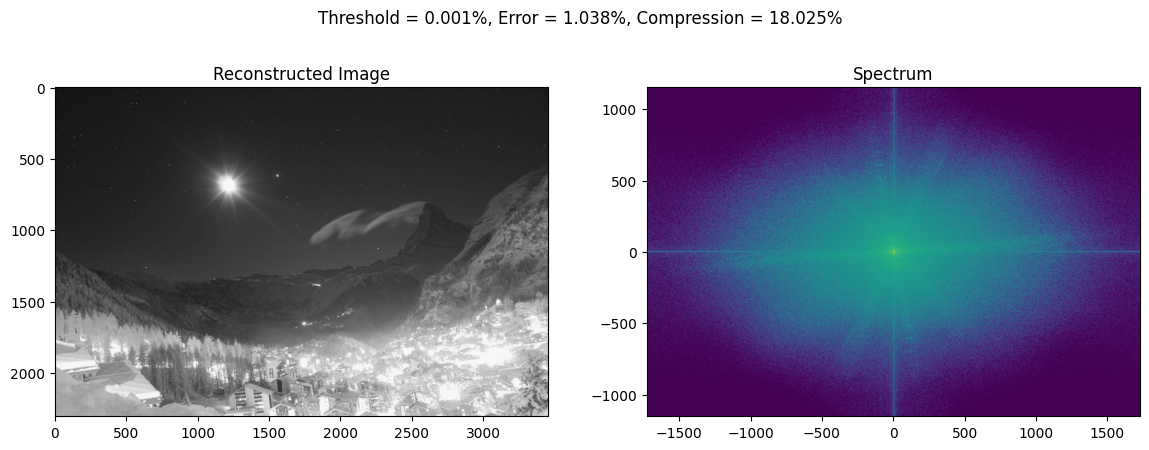

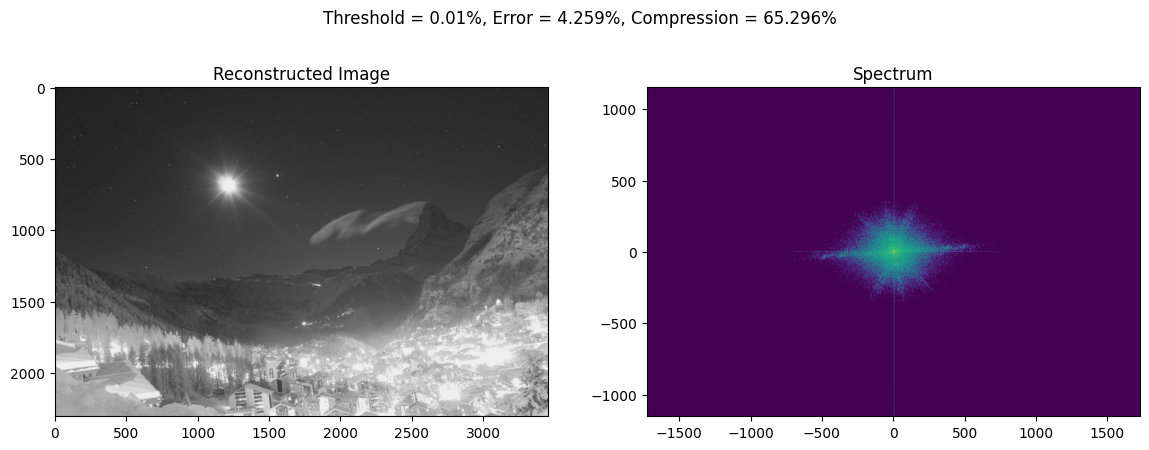

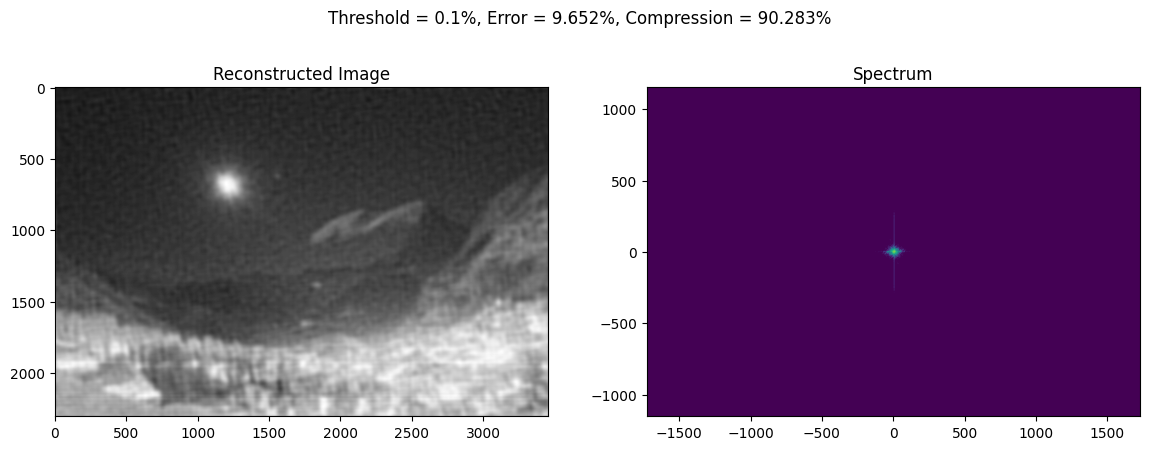

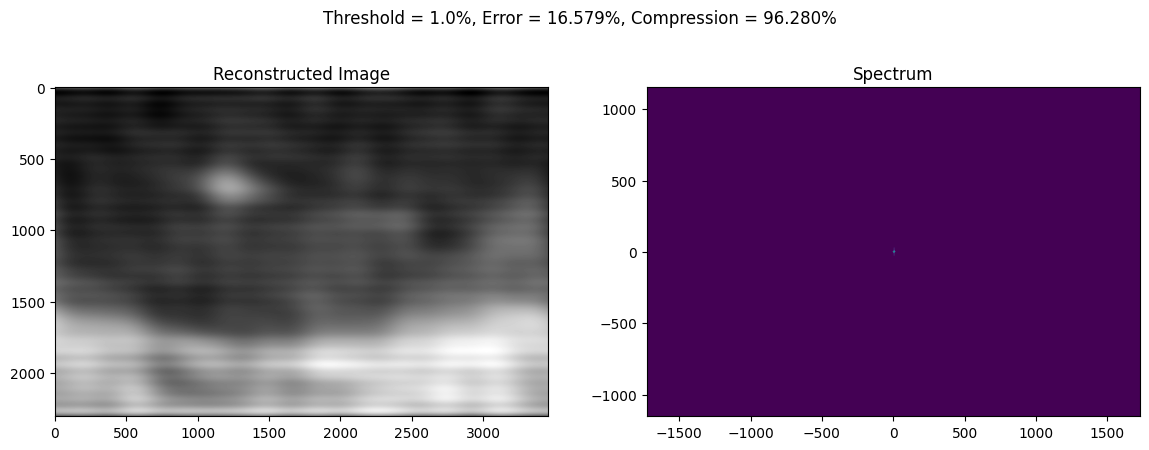

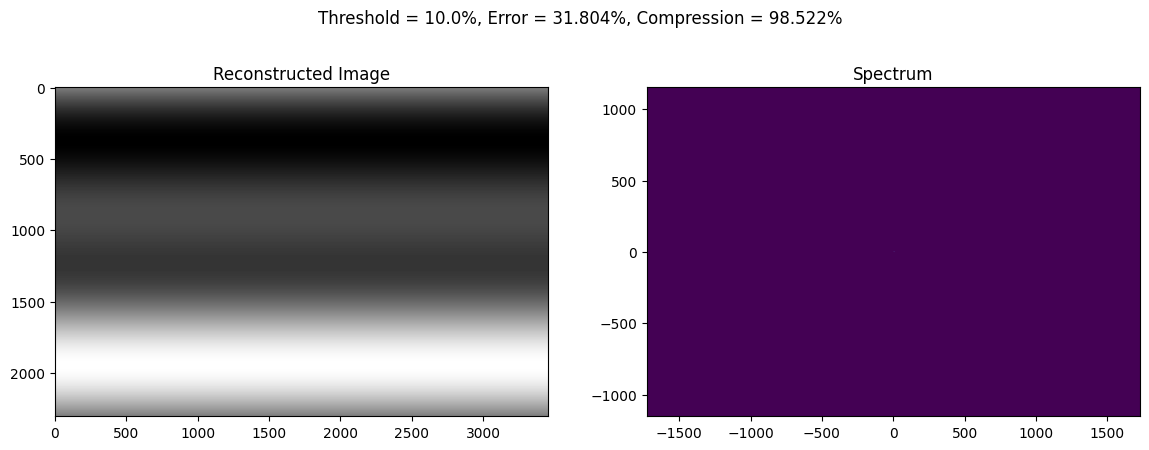

In [64]:
for threshold in [.00001, .0001, .001, .01, .1]:
    img_reconstructed, filtered_spectrum, error, data_kept = compress_and_reconstruct(
        img, threshold
    )

    plot_image_and_spectrum(
        img_reconstructed,
        filtered_spectrum,
        f"Threshold = {threshold*100}%, Error = {error*100:.3f}%, Compression = {(1-data_kept)*100:.3f}%",
    )

Je höher der Schwellenwert für die gefilterten Fourierkomponenten ist, desto mehr Komponenten werden aus dem Spektrum entfernt. Das bedeutet, dass weniger Frequenzen im rekonstruierten Bild enthalten sind, was zu einer Verringerung der Bildqualität führt. Mit einem höheren Schwellenwert werden mehr hohe Frequenzen entfernt, die für die feinen Details und Kanten im Bild verantwortlich sind. Daher wird das Bild mit zunehmendem Schwellenwert immer verschwommener und verliert mehr Details.

Der Schwellenwert ist ein Grenzwert, der dazu dient, Fourier-Komponenten auf der Grundlage ihrer Amplitude auszuwählen. Fourier-Komponenten mit einer Amplitude unterhalb des Schwellenwertes werden aus dem Spektrum entfernt, während Komponenten mit einer Amplitude oberhalb des Schwellenwertes beibehalten werden. Durch die Auswahl eines Schwellenwertes kann die Menge an Informationen, die im Bild gespeichert werden, reduziert werden, wodurch das Bild komprimiert wird. Je höher der Schwellenwert, desto stärker wird das Bild komprimiert.

### (c) - Fehlerberechnung
> Berechnen Sie den Fehler (`Aufgabe 1`) zwischen rekonstruiertem und Originalbild. Wie weit können die Daten kompressiert werden, ohne einen Fehler von höchstens $1$%  zu überschreiten?

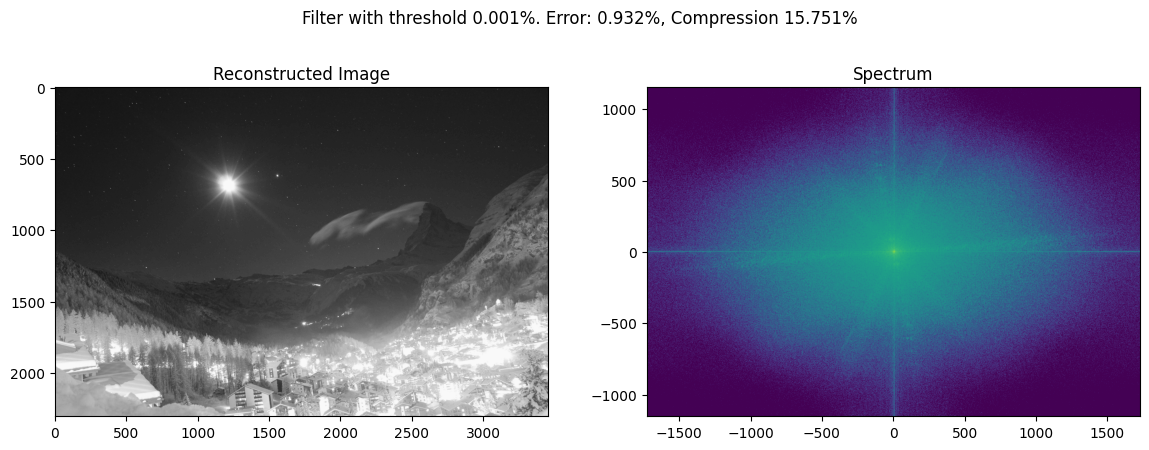

Maximum compression without exceeding 1% relative error is 15.751%


In [65]:
threshold, max_compression = 0, 0
step_size = 0.000001

while threshold <= 1:
    _, _, error, data_kept = compress_and_reconstruct(img, threshold)
    if error <= 0.01:  # 0.01 entspricht einem relativen Fehler von 1%
        max_compression = 1 - data_kept
        threshold += step_size
    else:
        break


img_reconstructed, filtered_spectrum, error, data_kept = compress_and_reconstruct(
    img, threshold - step_size
)

plot_image_and_spectrum(
    img_reconstructed,
    filtered_spectrum,
    f"Filter with threshold {threshold*100}%. Error: {error*100:.3f}%, Compression {max_compression*100:.3f}%",
)

print(f"Maximum compression without exceeding 1% relative error is {max_compression*100:.3f}%")

Der Relative Error eignet sich schlecht für die Bewertung von Bildkomprimierungen, da der Kontext von Bildstrukturen nicht beachtet wird. Vielmehr würde sich beispielsweise eine Metrik wie der [Structural Similarity Index Measure](https://www.wikiwand.com/en/Structural_similarity) eignen.

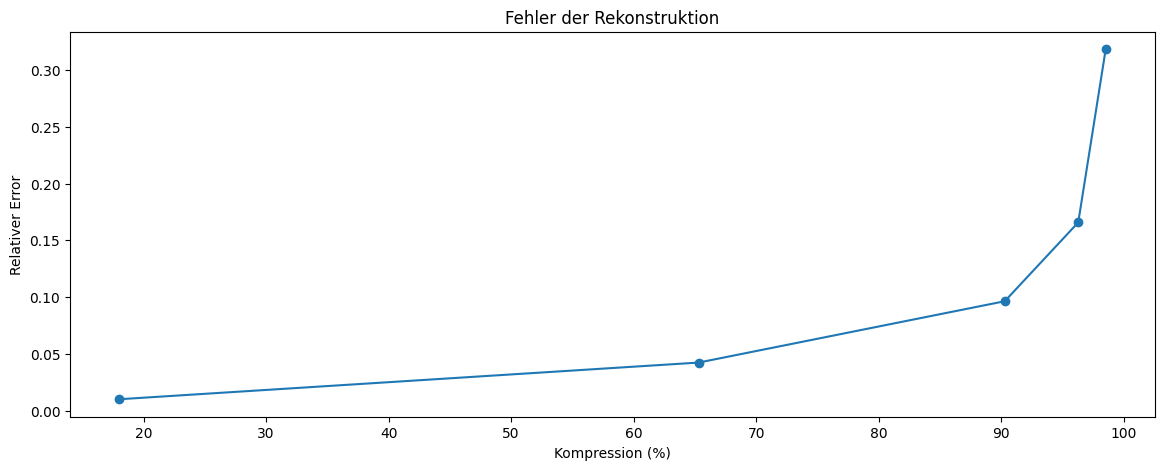

In [66]:
thresholds = [.00001, .0001, .001, .01, .1]
errors = []

compressions = []
for threshold in thresholds:
    img_reconstructed, _, error, data_kept = compress_and_reconstruct(img, threshold)
    compressions.append(1 - data_kept)
    errors.append(error)

plt.plot(np.array(compressions) * 100, errors, marker='o')
plt.xlabel("Kompression (%)")
plt.ylabel("Relativer Error")
plt.title("Fehler der Rekonstruktion")
plt.show()

## Zusammenfassung

Grundsätzlich ist alles eine induzierte Projektion. 

1. **Fourier-Approximation**: Der Code approximiert Funktionen mithilfe von Fourier-Reihen. Er berechnet die Fourier-Koeffizienten, approximiert die Funktionen und berechnet den relativen Fehler.

2. **Sonnenfleck-Datenanalyse**: Der Code führt eine Fourier-Analyse der Sonnenfleckendaten durch. Er berechnet die Fourier-Transformation, filtert das Spektrum und führt eine inverse Fourier-Transformation durch, um in den Zeitbereich zurückzukehren.

3. **Musik-Analyse und -Bearbeitung**: Der Code lädt eine Musikdatei, zeichnet ihre Wellenform und ihr Amplitudenspektrum auf, filtert das Spektrum, um einen Bandpassfilter zu erstellen, führt eine inverse Fourier-Transformation an dem gefilterten Spektrum durch und speichert das Ergebnis als neue Musikdatei.

Die Fourier-Analyse wird mit dem Algorithmus der schnellen Fourier-Transformation (FFT) durchgeführt. Die Filterung der Frequenzkomponenten erfolgt durch Multiplikation der Fourier-Transformation mit einer Maske. Der Code verwendet die Librosa-Bibliothek für die Audioverarbeitung und die NumPy-, SciPy- und Matplotlib-Bibliotheken für mathematische Berechnungen und Diagramme.

## Lerntagebuch


### KW 18


### KW 19



### KW20
#### Interpretation Negativer Frequenzen

Wir haben beim erarbeiten der `Aufgabe 3` einige Verständnisfragen geklärt. Dabei war nicht ganz klar ob der low- resp. high-pass filter auf das absolute oder nicht-absolute Frequenzspektrum angewandt werden sollte. In diesem Zusammenhang haben wir uns die Frage gestellt, welche Bedeutung die negativen Frequenzen haben:

Die Fourier-Transformation teilt ein Signal nicht in Sinuswellen, sondern in komplexe Exponentialfunktionen (auch "komplexe Sinuswellen" oder "cisoids" genannt) auf. Diese können als Spiralen im komplexen Raum dargestellt werden, die entweder links- oder rechtshändig (im Uhrzeigersinn oder gegen den Uhrzeigersinn) rotieren. Das Konzept der negativen Frequenz ergibt sich aus der Drehrichtung dieser Spiralen.

Bei realen Signalen gibt es immer zwei komplexe Exponentialfunktionen mit gleicher Amplitude, die in entgegengesetzten Richtungen rotieren. Ihre realen Teile kombinieren sich und ihre imaginären Teile heben sich auf, was ein reales Sinussignal hinterlässt. Daher hat das Spektrum einer Sinuswelle immer zwei Spitzen, eine mit positiver und eine mit negativer Frequenz.

Die negativen und positiven Frequenzkomponenten sind beide notwendig, um das reale Signal zu erzeugen. Wenn allerdings bereits bekannt ist, dass es sich um ein reales Signal handelt, bietet die andere Seite des Spektrums keine zusätzlichen Informationen und wird daher oft vernachlässigt. Im allgemeinen Fall komplexer Signale sind jedoch beide Seiten des Frequenzspektrums notwendig.

![](https://i.stack.imgur.com/eCpbp.gif)

Die Fourier-Transformation nutzt sowohl positive als auch negative Frequenzen, um ein reales Signal korrekt zu rekonstruieren. Die Realteile der komplexen Exponentialfunktionen kombinieren sich, während die Imaginärteile sich aufheben, um das ursprüngliche Signal zu erzeugen. Die Verwendung nur einer Seite des Spektrums würde zu einem komplexen Signal führen. Obwohl die andere Seite als redundant betrachtet werden kann, ist sie unerlässlich für die korrekte Rekonstruktion des Signals.

Referenz:
- [What is the physical significance of negative frequencies? - StackExchange](https://dsp.stackexchange.com/questions/431/what-is-the-physical-significance-of-negative-frequencies)
- [Is the negative spectrum (by DFT) of a real signal "needed" to reconstruct it? - StackExchange](https://dsp.stackexchange.com/questions/84769/is-the-negative-spectrum-by-dft-of-a-real-signal-needed-to-reconstruct-it)
- ChatGPT zur Formulierug des Texts basierend auf den Quellen


### KW21
#### Order matters
Bei `Aufgabe 2.c` haben wir festgestellt, dass die Reihenfolge in welcher wir Komponenten entfernen wichtig ist, da sonst die Aufgabe nicht sauber erfüllt ist. Desshalb ist es auch wichtig vor der Rücktransformation des Spektrum die Werte wieder zurück zu "shiften".

### KW22
#### Relative Error
Wir haben uns den relative error genauer angeschaut und herausgefunden, dass der RRMSE falsch implementiert wurde. Ebenfalls haben wir haben mit sum of coefficients herumgespielt, da dies angeblich auch eine angemessene Variante ist den Fehler zu bestimmen. 

#### Neagtive Sunspots nach Rücktransformation
Grund für die negativen Sunspots war, dass wir die Nullfrequenz entfernt haben, welche essentiell ist, um die Basislinie zu definieren. Sobald diese entfernt wird (wie bei $k>5$ zuerst der Fall) führt das dazu, dass das ganze Signal verschoben wird. Das inkludieren der Nullfrequenz löste das Problem. Die Null-Frequenzkomponente einer Fourier-Transformation repräsentiert den Durchschnitt oder die Gleichstromkomponente des Signals. Sie ist wichtig, um den Mittelwert des Signals zu erhalten. Wenn das Signal eine signifikante Gleichstromkomponente hat, wird sie als Spitze bei der Nullfrequenz sichtbar. Das Ignorieren dieser Komponente würde die Charakteristik der Daten verändern. Um dieses Problem zu vermeiden, kann man die Daten vor der Transformation normalisieren, damit der Durchschnitt der $y$-Werte bei null liegt.

Referenz:
- ChatGPT zur Formulierug des Texts basierend auf den Quellen und [erforschen der Theorie](https://chat.openai.com/share/94f30ba9-8e71-4e33-91ae-7639f0e09874) dahinter

#### Kompressionsfaktorberechnung bei Bildern

TODO

#### Interpretation von "$2m+1$ Komponenten"
Die Formulierung "$2m + 1$" bezieht sich auf die Anzahl der Terme in der Fourier-Reihe, die zur Approximation verwendet werden. Es werden sowohl positive als auch negative Frequenzen berücksichtigt, wodurch insgesamt "$2m + 1$" Terme entstehen. Diese Zahl gibt an, wie viele Fourier-Koeffizienten in der Approximation berücksichtigt werden sollen.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2c921941-9604-4099-90d4-1d4be742febc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>